In [133]:
# One-liner to start the debugger here.
#from IPython.core.debugger import Tracer; Tracer()()
#np.set_printoptions(threshold=np.inf)

import scipy.sparse as sp
import numpy as np
import time
import hashlib
import sys

In [134]:
def chunk_generator(fname, chunk_size=1000):
        data = []
        counter = 0

        with open(fname, 'r') as ifile:

            for line in ifile:
                if counter < chunk_size:
                    data.append([int(p) for p in line.split(" ")])
                    counter += 1
                if counter == chunk_size:
                    counter = 0
                    yield data
                    data = []
                    
            # process remaining elements
            if len(data) > 0:
                yield data

class ShingleFileParser:
    def __init__(self, fname):
        cindex = 0;
        for chunk in chunk_generator(fname, 40000):
            if cindex == 0 :
                self.D = chunk[0][0]
                self.W = chunk[1][0]
                self.X = sp.lil_matrix ((self.W,self.D))
                for i in range(3,len(chunk)):
                    self.add_to_matrix(chunk[i])
            else:
                for line in chunk :
                    self.add_to_matrix(line)
            cindex = cindex + 1
        
    def add_to_matrix(self,item):
            D_i = item[0] - 1
            W_i = item[1] - 1
            self.X[W_i,D_i] = 1
    
    def save_csc(self,filename):
        print("converting to csc (column-access optimized) sparse format ...")
        self.X = sp.csc_matrix(self.X)
        print("saving matrix with " + str(len(self.X.data)) + " elements")
        np.savez(filename,data = self.X.data ,indices=self.X.indices,
                 indptr = self.X.indptr, shape = self.X.shape)
        print ("content saved to " + filename)

In [135]:
start = time.time()
sf_parser =  ShingleFileParser('../data/docword.kos.txt')
end = time.time()
print("Parsing the file took " + str(end - start) + " seconds")
sf_parser.save_csc('../data/csc_kos');
del sf_parser

Parsing the file took 2.42670607567 seconds
converting to csc (column-access optimized) sparse format ...
saving matrix with 353160 elements
content saved to ../data/csc_kos


In [136]:
def load_sparse_csc(filename):
    loader = np.load(filename)
    return sp.csc_matrix((  loader['data'], loader['indices'], loader['indptr']),
                         shape = loader['shape'])
D = load_sparse_csc('../data/csc_kos.npz')

In [137]:
def jaccard_similarity(A):
    # assumes that every document is a column-vector.
    # We will compute the "covariance" between every document to find how many elements are common.
    print ("performing union between shapes " + str(A.T.shape) + " and " + str(A.shape))
    intersect = A.T.dot(A)
    D_len = np.zeros([1,A.shape[1]])
    for i in range(0,A.shape[1]):
        D_len[0,i] = A[:,i].size
    # a bit tricky .. create 2 "meshes" of the sizes : one vertical and one horizontal
    cardinality_sum = np.array(np.meshgrid(D_len, D_len))
    # add up the 2 mesh grids .. this adds up all the pairs of 2 documents
    cardinality_sum = np.sum(cardinality_sum,axis=0)
    # |union(a, b)| == |a| + |b| - |intersection(a, b)|
    union = cardinality_sum - intersect
    J= np.divide(intersect.todense(),union)
    return J

In [138]:
start = time.time()
# this contains duplicates (J[a,b] =J[b,a]). 
J = jaccard_similarity(D)
end = time.time()
print("Computing Jaccard similarity matrix took " + str(end - start) + " seconds")
# Also the diagonal would need to be ignored, since documents are similar to themselves
np.mean(J)

performing union between shapes (3430, 6906) and (6906, 3430)
Computing Jaccard similarity matrix took 2.21264910698 seconds


0.03378473014650963

In [139]:
def find_next_prime(n):
    def find_prime_in_range(a, b):
            for p in range(a, b):
                for i in range(2, p):
                    if p % i == 0:
                        break
                else:
                     return p
            return None
    return find_prime_in_range(n, 2 * n)

In [140]:
def universal_row_hashes(h_sz,r_sz):
    N_prime = find_next_prime(r_sz)
    R = np.matrix(np.linspace(1,r_sz,r_sz,dtype=int))
    coef = np.random.randint(low=1,high=r_sz,size=[h_sz,2])
    A = np.matrix(coef[:,0]).T
    B = np.matrix(coef[:,1]).T
    H = (A * R + B )% N_prime % h_sz
    return H

In [141]:
import matplotlib.pyplot as plt
def show_hash_distribution(H):
    # check out the distribution of these random hash results
    plt.hist(np.asarray(H).flatten())
    plt.show()

In [142]:
def minhash_signature(A,h_sz,show_hash_buckets=False):
    D = A.shape[1]
    W = A.shape[0]
    H = universal_row_hashes(h_sz,W)
    if show_hash_buckets:
        print("showing hash value distribution of words in the document using " 
                  + str(h_sz) + " distinct hash functions")
        show_hash_distribution(H)
    SGN = np.matrix(np.full([h_sz,D],sys.maxint))
    nz = A.nonzero()
    for i_nz in range(0,A.nnz):
        w_i = nz[0][i_nz]
        d_i = nz[1][i_nz]
        SGN[:,d_i] = np.minimum(H[:,w_i],SGN[:,d_i])
    return SGN

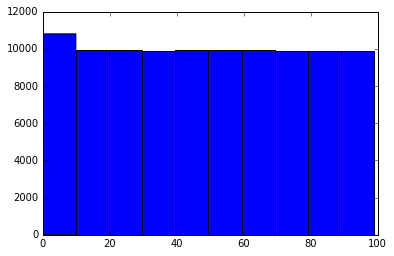

In [144]:
show_hash_distribution(universal_row_hashes(100,1000))

showing hash value distribution of words in the document using 100 distinct hash functions


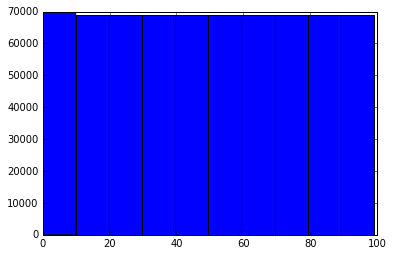

matrix([[ 1.,  1.,  1., ...,  0.,  2.,  0.],
        [ 0.,  0.,  0., ...,  2.,  2.,  0.],
        [ 1.,  2.,  0., ...,  2.,  0.,  0.],
        ..., 
        [ 2.,  3.,  1., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.]])

In [145]:
Sig = minhash_signature(D,100,show_hash_buckets=True)
Sig

In [146]:
M = np.matrix([
    [0, 3, 0],
    [0, 0, 3],
    [1, 1, 1],
    [2, 0, 2]
])
def SIG_sparse_matrix(S, debug=False):
    H = S.shape[0]
    D = S.shape[1]
    print "initializing sparse matrix with shape " + str((H*H,D))
    SIG_sp = sp.lil_matrix ((H*H,D),dtype=int)
    print "Succesful"
    ix = 0
    for i_H in range(0,H):
        for i_D in range(0,D):
            ix = ix + 1
            h_val = S[i_H,i_D]
            i_sp_H = i_H*H+h_val
            i_sp_D = i_D
            if debug and ix %5000  == 0:
                print(str((i_sp_H,i_sp_D)))
            #    from IPython.core.debugger import Tracer; Tracer()()
            SIG_sp[i_sp_H,i_sp_D] = 1
    return SIG_sp
S = SIG_sparse_matrix(M,debug=True)
print(S.nonzero())
print(jaccard_similarity(SIG_sparse_matrix(M)))

initializing sparse matrix with shape (16, 3)
Succesful
(array([ 0,  0,  3,  4,  4,  7,  9,  9,  9, 12, 14, 14], dtype=int32), array([0, 2, 1, 0, 1, 2, 0, 1, 2, 1, 0, 2], dtype=int32))
initializing sparse matrix with shape (16, 3)
Succesful
performing union between shapes (3, 16) and (16, 3)
[[ 1.          0.33333333  0.6       ]
 [ 0.33333333  1.          0.14285714]
 [ 0.6         0.14285714  1.        ]]


In [82]:
def grid_search_MinHash_buckets(A,search_range,verbose=False):
    J_SGN= {}
    for k in search_range:
        start = time.time()
        Sig = minhash_signature(A,k)
        end = time.time()
        minhash_time = end - start
        if verbose:
            print("Computing the minHash signatures with K = " + str(k) + " took " + str(minhash_time) + " seconds")
        start = time.time()
        J_appr = jaccard_similarity(SIG_sparse_matrix(Sig))
        end = time.time()
        jaccard_time = end - start
        if verbose:
            print("Computing the Jaccard similarity with K = " + str(k) + " took " + str(jaccard_time) + " seconds")
        J_SGN[k] = {"J_SGN":J_appr,"minhash_time":minhash_time,"jaccard_time":jaccard_time}
    return J_SGN
J_approx_list = grid_search_MinHash_buckets(D,range(10,101,10))

initializing sparse matrix with shape (100, 3430)
Succesful
performing union between shapes (3430, 100) and (100, 3430)
initializing sparse matrix with shape (400, 3430)
Succesful
performing union between shapes (3430, 400) and (400, 3430)
initializing sparse matrix with shape (900, 3430)
Succesful
performing union between shapes (3430, 900) and (900, 3430)
initializing sparse matrix with shape (1600, 3430)
Succesful
performing union between shapes (3430, 1600) and (1600, 3430)
initializing sparse matrix with shape (2500, 3430)
Succesful
performing union between shapes (3430, 2500) and (2500, 3430)
initializing sparse matrix with shape (3600, 3430)
Succesful
performing union between shapes (3430, 3600) and (3600, 3430)
initializing sparse matrix with shape (4900, 3430)
Succesful
performing union between shapes (3430, 4900) and (4900, 3430)
initializing sparse matrix with shape (6400, 3430)
Succesful
performing union between shapes (3430, 6400) and (6400, 3430)
initializing sparse matri

In [95]:
def MAE(J_true, J_approx):
    return np.mean(np.abs(J_true-J_approx))

def J_approximation_accuracy(J_true,J_list,verbose=False):
    accuracy={}
    for k in (J_list.keys()):
        mae = MAE(J_true,J_approx_list[k]["J_SGN"])
        if verbose:
            print ("k = " + str(k) + " MAE is " + str(mae))
        accuracy[k] = mae
    return accuracy

approx = J_approximation_accuracy(J,J_approx_list)

In [97]:
benchmark={}
for k in (J_approx_list.keys()):
    benchmark[k]={}
    benchmark[k]["MAE"] = approx[k]
    benchmark[k]["minhash_time"] = J_approx_list[k]["minhash_time"]
    benchmark[k]["jaccard_time"] = J_approx_list[k]["jaccard_time"]

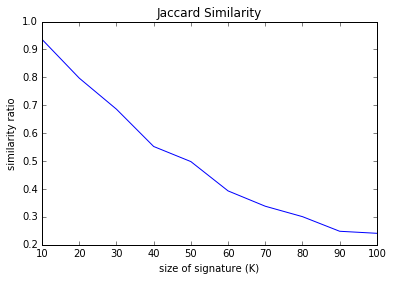

In [113]:
X = [i[0] for i in sorted(benchmark.items())]
Y = [i[1]['MAE'] for i in sorted(benchmark.items())]
plt.title("Jaccard Similarity")
plt.plot(X,Y)
plt.ylabel("similarity ratio")
plt.xlabel("size of signature (K)")
plt.show()

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


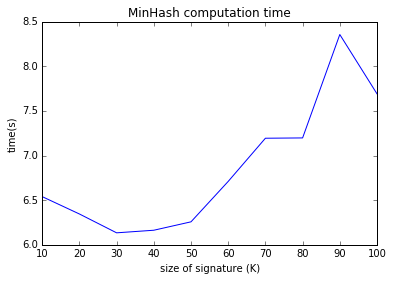

In [111]:
X = [i[0] for i in sorted(benchmark.items())]
print X
Y = [i[1]['minhash_time'] for i in sorted(benchmark.items())]
plt.title("MinHash computation time")
plt.plot(X,Y)
plt.ylabel("time(s)")
plt.xlabel("size of signature (K)")
plt.show()

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


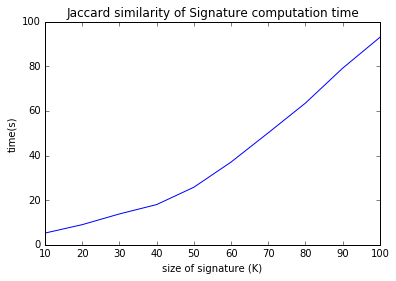

In [114]:
X = [i[0] for i in sorted(benchmark.items())]
print X
Y = [i[1]['jaccard_time'] for i in sorted(benchmark.items())]
plt.title("Jaccard similarity of Signature computation time")
plt.plot(X,Y)
plt.ylabel("time(s)")
plt.xlabel("size of signature (K)")
plt.show()

In [ ]:
def partition(seq, chunk_size):
    s = 0
    result = {}
    for i in range(len(seq)/chunk_size):
        result[i] = seq[s:s+chunk_size]
        s = s + chunk_size
    if len(seq) % chunk_size > 0:
        result[chunk_size+1] = seq[s:]
    return result

In [ ]:
# b and s are parameters to tweak for LSH
b = 10 # num of rows per band
s = 0.6 # similarity threshold (all values >= s will be taken under consideration for comparison)
K = 100
P_Sig = partition(sig, b)
# todo: hash each column portion with k butckets (k as large as possible, but I think 100 is too much here)
# todo: if 2 column portions hash to the same table - the columns are candidates for comparison (compare using Jaccard)